In [29]:
import os
import tensorflow as tf
import pandas as pd
from keras import layers, Model
from keras.callbacks import EarlyStopping

os.environ["KERAS_BACKEND"] = "tensorflow"

In [84]:
file_url = "http://storage.googleapis.com/download.tensorflow.org/data/heart.csv"
dataframe = pd.read_csv(file_url)

In [85]:
dataframe.shape

(303, 14)

In [87]:
"""
Here's a preview of a few samples:
"""
dataframe.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0


In [88]:
"""
Let's split the data into a training and validation set:
"""
val_dataframe = dataframe.sample(frac=0.2, random_state=1337)
train_dataframe = dataframe.drop(val_dataframe.index)
print(
    f"Using {len(train_dataframe)} samples for training "
    f"and {len(val_dataframe)} for validation"
)

Using 242 samples for training and 61 for validation


In [89]:
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("target")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe)).batch(32)
    return ds

In [90]:
"""
Let's generate `tf.data.Dataset` objects for each dataframe:
"""
train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)

In [91]:
def encode_feature(feature, name, dataset, is_string=False):
    lookup_class = layers.StringLookup if is_string else layers.IntegerLookup
    lookup = lookup_class(output_mode="binary")
    feature_ds = dataset.map(lambda x, y: x[name]).map(lambda x:tf.expand_dims(x, -1))
    lookup.adapt(feature_ds)
    return lookup(feature)

def normalize_feature(feature, name, dataset):
    normalizer = layers.Normalization()
    feature_ds = dataset.map(lambda x, y: tf.expand_dims(x[name], -1))
    normalizer.adapt(feature_ds)
    return normalizer(feature)

In [92]:
inputs = {
        'age': layers.Input(name='age', shape=(1,), dtype='float32'),
        'sex': layers.Input(name='sex', shape=(1,), dtype='int64'),
        'cp': layers.Input(name='cp', shape=(1,), dtype='int64'),
        'trestbps': layers.Input(name='trestbps', shape=(1,),dtype='float32'),
        'chol': layers.Input(name='chol', shape=(1,), dtype='float32'),
        'fbs': layers.Input(name='fbs', shape=(1,), dtype='int64'),
        'restecg': layers.Input(name='restecg', shape=(1,), dtype='int64'),
        'thalach': layers.Input(name='thalach', shape=(1,), dtype='float32'),
        'exang': layers.Input(name='exang', shape=(1,), dtype='int64'),
        'oldpeak': layers.Input(name='oldpeak', shape=(1,), dtype='float32'),
        'slope': layers.Input(name='slope', shape=(1,), dtype='int64'),
        'ca': layers.Input(name='ca', shape=(1,), dtype='int64'),
        'thal': layers.Input(name='thal', shape=(1,), dtype='string'),
}

encoded_features = [
        encode_feature(inputs['sex'], 'sex', train_ds),
        encode_feature(inputs['cp'], 'cp', train_ds),
        encode_feature(inputs['fbs'], 'fbs', train_ds),
        encode_feature(inputs['restecg'], 'restecg', train_ds),
        encode_feature(inputs['exang'], 'exang', train_ds),
        encode_feature(inputs['ca'], 'ca', train_ds),
        encode_feature(inputs['thal'], 'thal', train_ds, is_string=True),
        normalize_feature(inputs['age'], 'age', train_ds),
        normalize_feature(inputs['trestbps'], 'trestbps', train_ds),
        normalize_feature(inputs['chol'], 'chol', train_ds),
        normalize_feature(inputs['thalach'], 'thalach', train_ds),
        normalize_feature(inputs['oldpeak'], 'oldpeak', train_ds),
        normalize_feature(inputs['slope'], 'slope', train_ds)
]


Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.3432 - loss: 0.8169 - val_accuracy: 0.4098 - val_loss: 0.7572
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4672 - loss: 0.7338 - val_accuracy: 0.5410 - val_loss: 0.6831
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5911 - loss: 0.6711 - val_accuracy: 0.6066 - val_loss: 0.6241
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6811 - loss: 0.6057 - val_accuracy: 0.7049 - val_loss: 0.5744
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7559 - loss: 0.5601 - val_accuracy: 0.7377 - val_loss: 0.5332
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7426 - loss: 0.5371 - val_accuracy: 0.8033 - val_loss: 0.5008
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8039 - loss: 0.4852 - val_accuracy: 0.8033 - val_loss: 0.4737
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8131 - loss: 0.4674 - val_accuracy: 0.8033 - val_loss: 0.4534
Epoch 9

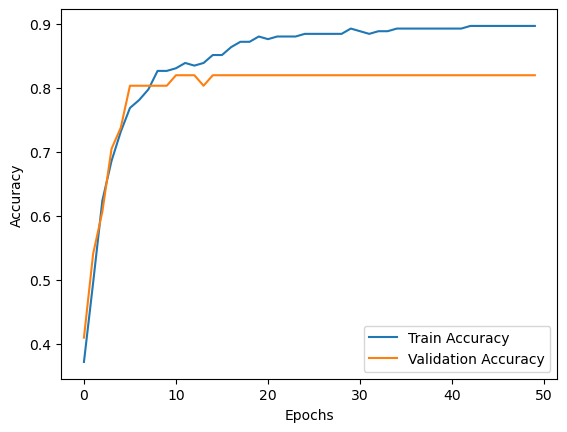

In [93]:
def build_model():

    all_features = layers.concatenate(encoded_features)
    x = layers.Dense(32, activation='relu')(all_features)

    output = layers.Dense(1, activation='sigmoid')(x)

    model = Model(inputs, output)
    model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
    
    return model

model = build_model()

history = model.fit(train_ds, epochs=50, validation_data=val_ds)

import matplotlib.pyplot as plt
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [94]:
sample = {
    "age": 60, "sex": 1, "cp": 1, "trestbps": 145, "chol": 233,
    "fbs": 1, "restecg": 2, "thalach": 150, "exang": 0,
    "oldpeak": 2.3, "slope": 3, "ca": 0, "thal": "fixed",
}
input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
predictions = model.predict(input_dict)
print(f"This patient has a {100 * predictions[0][0]:.1f}% probability of heartdisease.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
This patient has a 28.5% probability of heartdisease.


Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.4349 - loss: 0.7512 - val_accuracy: 0.5738 - val_loss: 0.6738
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6831 - loss: 0.6175 - val_accuracy: 0.7377 - val_loss: 0.5570
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8069 - loss: 0.5212 - val_accuracy: 0.8033 - val_loss: 0.4825
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8150 - loss: 0.4598 - val_accuracy: 0.8033 - val_loss: 0.4365
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8302 - loss: 0.4204 - val_accuracy: 0.8197 - val_loss: 0.4114
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8260 - loss: 0.4002 - val_accuracy: 0.8361 - val_loss: 0.3969
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8568 - loss: 0.3585 - val_accuracy: 0.8361 - val_loss: 0.3881
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8613 - loss: 0.3494 - val_accuracy: 0.8361 - val_loss: 0.3872
Epoch 9

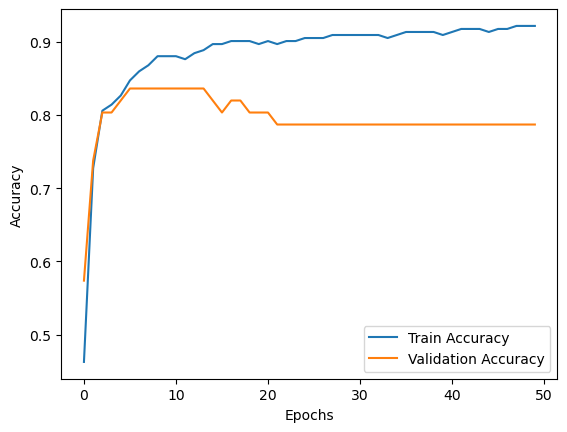

In [96]:
def build_model():

    all_features = layers.concatenate(encoded_features)
    x = layers.Dense(128, activation='relu')(all_features)

    output = layers.Dense(1, activation='sigmoid')(x)

    model = Model(inputs, output)
    model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
    return model

model = build_model()

history = model.fit(train_ds, epochs=50, validation_data=val_ds)

import matplotlib.pyplot as plt
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.5471 - loss: 0.6855 - val_accuracy: 0.6721 - val_loss: 0.6303
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6739 - loss: 0.6098 - val_accuracy: 0.7541 - val_loss: 0.5513
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7534 - loss: 0.5212 - val_accuracy: 0.7377 - val_loss: 0.4961
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7757 - loss: 0.4860 - val_accuracy: 0.7705 - val_loss: 0.4580
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8240 - loss: 0.4177 - val_accuracy: 0.7541 - val_loss: 0.4298
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8184 - loss: 0.4188 - val_accuracy: 0.7541 - val_loss: 0.4117
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8398 - loss: 0.3898 - val_accuracy: 0.7869 - val_loss: 0.3996
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8511 - loss: 0.3687 - val_accuracy: 0.7869 - val_loss: 0.3927
Epoch 9

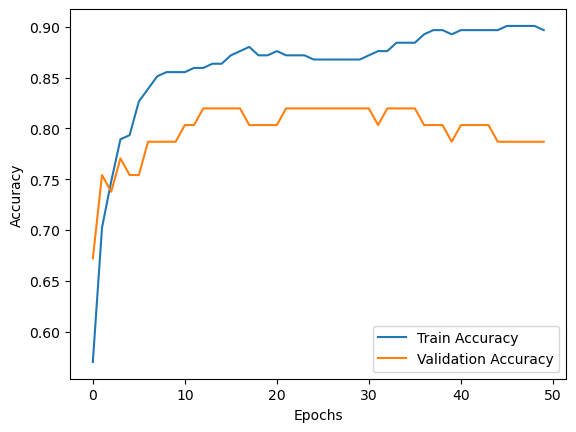

In [97]:
def build_model():

    all_features = layers.concatenate(encoded_features)
    x = layers.Dense(32, activation='tanh')(all_features)

    output = layers.Dense(1, activation='sigmoid')(x)

    model = Model(inputs, output)
    model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
    return model

model = build_model()

history = model.fit(train_ds, epochs=50, validation_data=val_ds)

import matplotlib.pyplot as plt
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.5676 - loss: 0.6610 - val_accuracy: 0.7377 - val_loss: 0.6054
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6693 - loss: 0.6077 - val_accuracy: 0.7705 - val_loss: 0.5461
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7700 - loss: 0.5477 - val_accuracy: 0.8525 - val_loss: 0.5014
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7370 - loss: 0.5422 - val_accuracy: 0.8197 - val_loss: 0.4688
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8037 - loss: 0.4963 - val_accuracy: 0.8197 - val_loss: 0.4438
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7464 - loss: 0.4830 - val_accuracy: 0.8033 - val_loss: 0.4249
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7698 - loss: 0.4604 - val_accuracy: 0.8033 - val_loss: 0.4112
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8254 - loss: 0.4218 - val_accuracy: 0.8033 - val_loss: 0.4014
Epoch 9

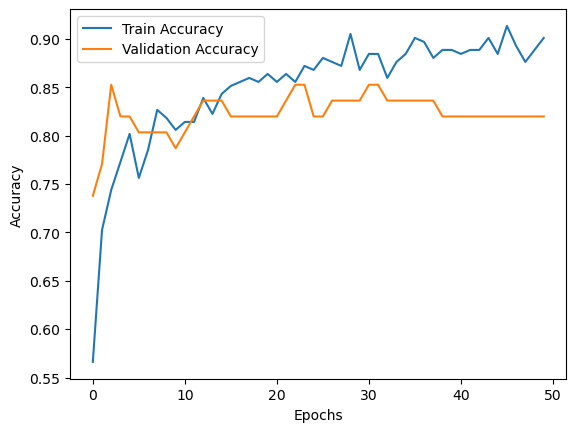

In [98]:
def build_model():

    all_features = layers.concatenate(encoded_features)
    x = layers.Dense(32, activation='relu')(all_features)
    x = layers.Dropout(0.3)(x)

    output = layers.Dense(1, activation='sigmoid')(x)

    model = Model(inputs, output)
    model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
    return model

model = build_model()

history = model.fit(train_ds, epochs=50, validation_data=val_ds)

import matplotlib.pyplot as plt
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.3871 - loss: 0.8728 - val_accuracy: 0.4590 - val_loss: 0.7183
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4715 - loss: 0.7904 - val_accuracy: 0.6230 - val_loss: 0.6691
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4964 - loss: 0.7460 - val_accuracy: 0.7049 - val_loss: 0.6231
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6265 - loss: 0.6341 - val_accuracy: 0.7541 - val_loss: 0.5860
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6689 - loss: 0.6446 - val_accuracy: 0.7705 - val_loss: 0.5572
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6254 - loss: 0.6438 - val_accuracy: 0.7705 - val_loss: 0.5333
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6605 - loss: 0.6243 - val_accuracy: 0.8033 - val_loss: 0.5124
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6987 - loss: 0.6047 - val_accuracy: 0.7869 - val_loss: 0.4935
Epoch 9

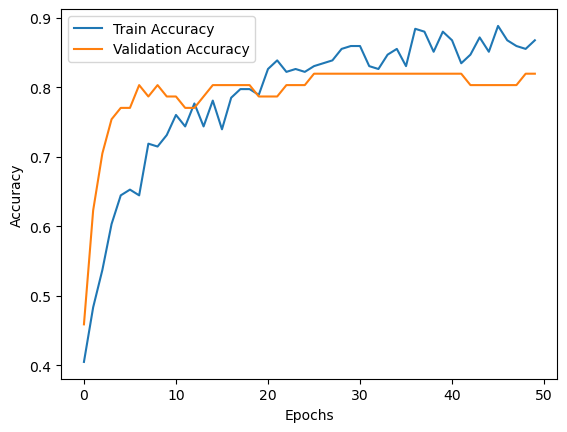

In [99]:
def build_model():

    all_features = layers.concatenate(encoded_features)
    x = layers.Dense(32, activation='relu')(all_features)
    x = layers.Dropout(0.7)(x)

    output = layers.Dense(1, activation='sigmoid')(x)

    model = Model(inputs, output)
    model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
    return model

model = build_model()

history = model.fit(train_ds, epochs=50, validation_data=val_ds)

import matplotlib.pyplot as plt
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4253 - loss: 0.9053 - val_accuracy: 0.4426 - val_loss: 0.7036
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4969 - loss: 0.7962 - val_accuracy: 0.7377 - val_loss: 0.6188
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5976 - loss: 0.7194 - val_accuracy: 0.8033 - val_loss: 0.5561
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6390 - loss: 0.6334 - val_accuracy: 0.8197 - val_loss: 0.5105
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6630 - loss: 0.6149 - val_accuracy: 0.8197 - val_loss: 0.4772
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7310 - loss: 0.5283 - val_accuracy: 0.8033 - val_loss: 0.4521
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6917 - loss: 0.5761 - val_accuracy: 0.8197 - val_loss: 0.4326
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7438 - loss: 0.5252 - val_accuracy: 0.8197 - val_loss: 0.4163
Epoch 9

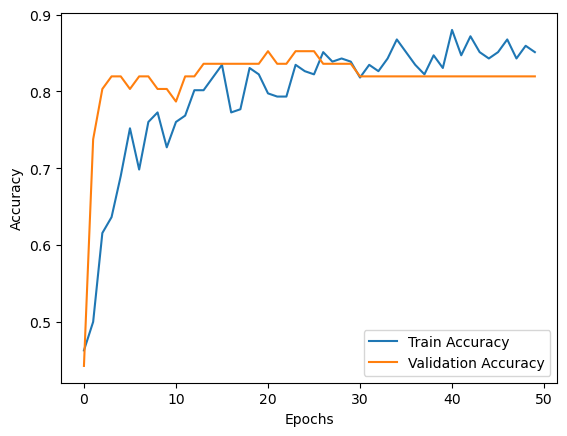

In [127]:
def build_model():

    all_features = layers.concatenate(encoded_features)
    x = layers.Dense(160, activation='relu')(all_features)
    x = layers.Dropout(0.9)(x)

    output = layers.Dense(1, activation='sigmoid')(x)

    model = Model(inputs, output)
    model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
    return model

model = build_model()

history = model.fit(train_ds, epochs=50, validation_data=val_ds)

import matplotlib.pyplot as plt
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()